<a href="https://colab.research.google.com/github/yulucy19/Thinkful-Project-2019/blob/master/Sentiment_Analysis_for_Amazon_Reviews_using_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis for Amazon Reviews using Spark**

In this project, we'll work on a sentiment analysis dataset: the Amazon reviews dataset. 

It's always important to start with a clear goal in mind. In this case, we'd like to determine if we can predict whether a review is positive or negative based on the language in the review.

We're going to tackle this problem with Spark, and some tips to help us get started:

* Pyspark always needs to point at a running Spark instance. You can do that using a SparkContext.
* We're working in batch mode, so you'll need to load an entire file into memory in order to run any models you build.
* Spark likes to execute models in a pipeline, so remember that when the time comes to set up your model.
* Spark's machine learning algorithms expect numeric variables.

## Spark and Colaboratory Setup

First, there is some configration specific to running Spark on Colaboratory that we'll need to attend to. Run these cells to set everything up.

In [0]:
# Install Apache Spark 2.4.5 and Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 217.8MB 61kB/s 
     |████████████████████████████████| 204kB 35.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=e5a9c7db1ad45c6c1e0f712c672f246b38ad79be0f4250b10aa82dd53e8b4699
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
# Point Colaboratory to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


##  Import dependencies

Next, we need to import the tools we'll need from PySpark. The imports below allow us to connect to the Spark server, load our data, clean it, and prepare, execute, and evaluate a model.

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

## Set our constants
Next, we create a set of constants that we can refer to throughout the notebook. These are values that the rest of our code needs to run, but that we might need to change at some point (for instance, if the location of our data changes).

The relevant datasets have been saved in my Google Drive folders.

In [0]:
JSON_PATH = "/content/gdrive/My Drive/Colab Datasets/Amazon_Instant_Video_5.json" 
#JSON_ACTIVITY_LABEL_PATH = "/content/gdrive/My Drive/Colab Datasets/Amazon_Instant_Video_5.json"
APP_NAME = "Sentiment Analysis for Amazon Instant Video Reviews"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

## Connect to the server and load data
Now we're ready to connect to the Spark server. We do that (relying on the constants set above) and then load our data (loaded into `video_df`).

The first thing we always do is create a SparkContext, and then immediately afterward create a sqlContext to be able to load and manipulate an RDD/dataframe.

In [0]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
# Load data directly from sc.read.options
#video_orig_df = sc.read.options(inferschema = "true").json(JSON_PATH)

# Let's try loading data from SQLContext
sqlContext = SQLContext(sc)
video_orig_df = sqlContext.read.json(JSON_PATH)

video_df = video_orig_df
video_df.show(10)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|B000H00VBQ|  [0, 0]|    2.0|I had big expecta...| 05 3, 2014|A11N155CW1UV02|            AdrianaM|A little bit bori...|    1399075200|
|B000H00VBQ|  [0, 0]|    5.0|I highly recommen...| 09 3, 2012|A3BC8O2KCL29V2|             Carol T|Excellent Grown U...|    1346630400|
|B000H00VBQ|  [0, 1]|    1.0|This one is a rea...|10 16, 2013| A60D5HQFOTSOM|Daniel Cooper "da...|Way too boring fo...|    1381881600|
|B000H00VBQ|  [0, 0]|    4.0|Mysteries are int...|10 30, 2013|A1RJPIGRSNX4PW|      J. Kaplan "JJ"|Robson Green is m...|    1383091200|
|B000H00VBQ|  [1, 1]|    5.0|This show always ...|02 11

## Explore the data

In [0]:
# Let's check the data set shape.
print("Amazoninstantvideo dataset has {} rows and {} columns.".format(video_df.count(), len(video_df.columns)))

Amazoninstantvideo dataset has 37126 rows and 9 columns.


In [0]:
video_df.columns

['asin',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime']

For this sentiment analysis, from the above data table, we can see that overall column-numeric column will be our target column for performing supervised learning. And reviewText will be independent variable for the analysis. But this column is text data, we will use word2vec to convert the text review data into numerical vectors.

Overall column is numerical data on a scale of 1 to 5. For sentiment analysis, we will convert this column into binary data:
positive sentiment as 1 and negative sentiment as 0. 

* If overall value > 3, it is positive as 1
* If overall value <=3, it is negative as 0.

we will add another column in the dataset as overall_bin which will be our target or Y variable.

Before we get going on our data preparation, let's take a look at the columns we mentioned above.

To perform a SQL query on a dataframe, we need to create a `tempTable`.



In [0]:
# Check the 'overall' column statistical description.
video_df.describe("overall").show()

+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|             37126|
|   mean| 4.209529709637451|
| stddev|1.1185496668776904|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [0]:
# Create a TempTable
video_df.registerTempTable('videoreviews')

# Perform a SQL query to the column of "overall"
sqlContext.sql("SELECT overall, count(overall) as reviewcount FROM videoreviews GROUP BY overall ORDER BY overall desc").show()

+-------+-----------+
|overall|reviewcount|
+-------+-----------+
|    5.0|      20890|
|    4.0|       8446|
|    3.0|       4187|
|    2.0|       1885|
|    1.0|       1718|
+-------+-----------+



From the above statistical description table and reviewcount table, it can be seen thant most reviews are postive reviews about 78% (4.0+5.0)

In [0]:
# Now let's add a new column overall_bin with number of 0 (negative sentiment) and 1(positive sentiment) from User Defined Function.
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else 0, IntegerType())
video_df1 = video_df.withColumn('overall_bin', udf(video_df.overall))
video_df1.show(5)

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-----------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|overall_bin|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-----------+
|B000H00VBQ| [0, 0]|    2.0|I had big expecta...| 05 3, 2014|A11N155CW1UV02|            AdrianaM|A little bit bori...|    1399075200|          0|
|B000H00VBQ| [0, 0]|    5.0|I highly recommen...| 09 3, 2012|A3BC8O2KCL29V2|             Carol T|Excellent Grown U...|    1346630400|          1|
|B000H00VBQ| [0, 1]|    1.0|This one is a rea...|10 16, 2013| A60D5HQFOTSOM|Daniel Cooper "da...|Way too boring fo...|    1381881600|          0|
|B000H00VBQ| [0, 0]|    4.0|Mysteries are int...|10 30, 2013|A1RJPIGRSNX4PW|      J. Kaplan "JJ"|Robson Green is m...|    13

([<matplotlib.axis.XTick at 0x7fd071ff9160>,
 [Text(0, 0, '1'), Text(0, 0, '0')])

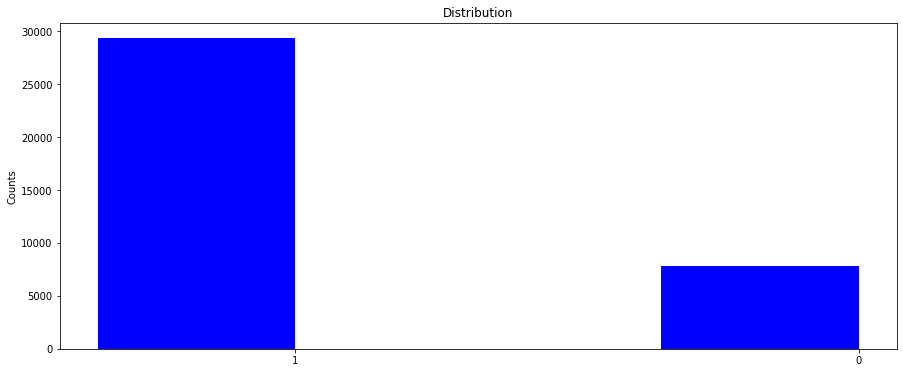

In [0]:
# Plot the count of positive and negative reviews
plt.rcParams['figure.figsize'] = (15, 6)

review_bin = video_df1.groupBy('overall_bin').count().collect()

categories = [i[0] for i in review_bin]
counts = [i[1] for i in review_bin]

ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='b')

plt.ylabel('Counts')
plt.title('Distribution')
plt.xticks(ind +width/2, categories)

From the above graph, it can see that the data is imbalance.

Next, let's take a look at the relevant columns.

In [0]:
video_df1.select('overall', 'overall_bin','reviewText', 'summary').show(10)

+-------+-----------+--------------------+--------------------+
|overall|overall_bin|          reviewText|             summary|
+-------+-----------+--------------------+--------------------+
|    2.0|          0|I had big expecta...|A little bit bori...|
|    5.0|          1|I highly recommen...|Excellent Grown U...|
|    1.0|          0|This one is a rea...|Way too boring fo...|
|    4.0|          1|Mysteries are int...|Robson Green is m...|
|    5.0|          1|This show always ...|Robson green and ...|
|    5.0|          1|I discovered this...|I purchased the s...|
|    3.0|          0|It beats watching...|It takes up your ...|
|    3.0|          0|There are many ep...|A reasonable way ...|
|    5.0|          1|This is the best ...|           kansas001|
|    3.0|          0|Not bad.  Didn't ...| Entertaining Comedy|
+-------+-----------+--------------------+--------------------+
only showing top 10 rows



## Tokenize the review text data

In [0]:
tokenizer = Tokenizer(inputCol='reviewText', outputCol='token_text').transform(video_df1)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol='token_text', outputCol='w2v_vector').fit(tokenizer)

w2vdf = word2Vec.transform(tokenizer)
#w2vdf.show(10)

In [0]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_bin: integer (nullable = true)
 |-- token_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



## Build a model and run our classfier in Spark

After we have everything in numeric format, we are ready to reshape the data and run the random forest model. 

In this project, we will use __Random Forest__, and __Logistic Regression__,  to build models for predicting sentiments. The scores from all supervised techniques were compared and then decided which technique to be selected for supervised models.

In spark, we manipulate the data to work in a spark pipeline, define each of the steps in the pipeline, chain them together, and finally run the pipeline.

Apache Spark classifiers expect 2 columns of input:
1. __labels__: an indexed set of numeric variable that respect the classification from the set of features we provide.
2. __features__: an indexed, vector variable that contains all of the feature values in each row.

In order to do this, we need to create these 2 columns from our dataset - the data is there, but not yet in a format we can use for the classifier. 

To create the indexed label column, we'll create a column called `indexedLabel` using the `StringIndexer` method. We use the column `overall_bin` as the source for label index since that contains our labels. 

To create indexed features column, we'll need to use `w2v_vector` columns from our data frame. We'll call this vector `indexedFeatures`.

Since the classifier expects indexed labels and an indexed vector column of data, we'll use the `indexedLabel` and `indexedFeatures` as input to our supervised learning models.

Note that now all data is in w2vdf object not in the original video_df1.

Let's confirm that the features are there. It's easy to do this in Apache Spark using the select and show methods on the dataframe.

In [0]:
w2vdf.select('overall_bin','reviewText','token_text','w2v_vector').show(5)

+-----------+--------------------+--------------------+--------------------+
|overall_bin|          reviewText|          token_text|          w2v_vector|
+-----------+--------------------+--------------------+--------------------+
|          0|I had big expecta...|[i, had, big, exp...|[-0.0262556820941...|
|          1|I highly recommen...|[i, highly, recom...|[0.04453314543934...|
|          0|This one is a rea...|[this, one, is, a...|[0.00893908824162...|
|          1|Mysteries are int...|[mysteries, are, ...|[-0.0135645127941...|
|          1|This show always ...|[this, show, alwa...|[0.00328893336859...|
+-----------+--------------------+--------------------+--------------------+
only showing top 5 rows



Now we're ready to build teh indexers, split our data for training and testing, define our model, and finally chain everything together into a pipeline.

It's important to note that when we execute this cell, we're not actually running our model. At this point, we're only defining its parameters.

### Random Forest Model

In [0]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer (target variable)
labelIndexer = StringIndexer(inputCol="overall_bin", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector (independent variable)
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and test sets (20% held out for testing)
# set seed for reproducibility
(training, test) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO], seed=100)
print("Training Dataset Count: " + str(training.count()))
print("Test Dataset Count: " + str(test.count()))

#Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf])

Training Dataset Count: 29727
Test Dataset Count: 7399


This next cell runs the pipeline, delivering a trained model at the end of the process.

In [0]:
# Train model. This also runs the indexers.
model_rf = pipeline_rf.fit(training)

It is now easy to test our model and make predictions simply by using the model's transform method on the testData dataset.

In [0]:
# Make predictions
predictions_rf = model_rf.transform(test)

## Evaluate RF model

Now we can use the MulticlassClassificationEvaluator to test the RF model's accuracy.

In [0]:
# Select (prediction, true label) and compute test error.
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions_rf)

print(f"Test Error = {(1.0-accuracy):g}")
print(f"Accuracy = {accuracy:g}")


Test Error = 0.211245
Accuracy = 0.788755


We didn't do so well... but that's typical in data science work.

Now let's take a look at Logisitic Regression.

### Logistic Regression Model

In [0]:
from pyspark.ml.classification import LogisticRegression

# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer (target variable)
labelIndexer = StringIndexer(inputCol="overall_bin", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector (independent variable)
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and test sets (20% held out for testing)
# set seed for reproducibility
(training, test) = w2vdf.randomSplit([0.8, 0.2],seed=100)
#training.cache()

# Logistic Regression Model
lr = LogisticRegression(maxIter=20, regParam=0.05, elasticNetParam=0, labelCol="indexedLabel",featuresCol="indexedFeatures" )

pipeline_lr = Pipeline(stages=[labelIndexer, featureIndexer, lr])

# Train model. This also runs the indexers.
model_lr = pipeline_lr.fit(training)

# Make predictions
predictions_lr = model_lr.transform(test)

### Evaluate LR Model

In [0]:
# Select (prediction, true label) and compute test error.
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions_lr)

print(f"Test Error = {(1.0-accuracy):g}")
print(f"Accuracy = {accuracy:g}")


Test Error = 0.176645
Accuracy = 0.823355


## Conclusions

The accuracy of 0.823 for logistic regression model is more than 0.789 for random forest model. Random forest is a very good, robust and versatile method, however it’s no mystery that for high-dimensional sparse data it’s not a best choice. It is obvious that Logistic Regression will be our model in this project.



Here's where you can go from here:

1. Cross validation for logistic regression to see any improvement for the model
2. Use a different method to tokenize and convert the text to numeric (TF/IDF, etc).
